In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

     |████████████████████████████████| 485.5 MB 687 bytes/s 
     |████████████████████████████████| 463 kB 56.0 MB/s 
     |████████████████████████████████| 12.8 MB 44.3 MB/s 
     |████████████████████████████████| 5.8 MB 13.4 MB/s 
     |████████████████████████████████| 2.3 MB 38.5 MB/s 
     |████████████████████████████████| 1.3 MB 37.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0 which is incompatible.


In [ ]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 109 kB 7.6 MB/s 
     |████████████████████████████████| 4.0 MB 6.8 MB/s 


In [ ]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

73728/61306 [====================================] - 0s 0us/step


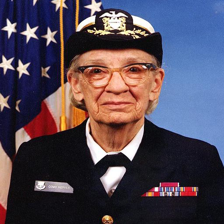

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


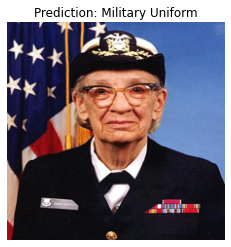

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228827136/228813984 [==============================] - 2s 0us/step


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['titi', 'vase', 'daisy', 'pot', 'daisy', 'cardoon', 'daisy',
       'goose', 'sulphur butterfly', 'red wine', 'bee', 'coral fungus',
       'daisy', 'volcano', 'picket fence', 'picket fence', 'daisy',
       'vase', 'hip', "yellow lady's slipper", 'daisy', 'cauliflower',
       'daisy', 'ear', 'daisy', 'picket fence', 'velvet', 'shower cap',
       'barn spider', 'daisy', 'daisy', 'daisy'], dtype='<U30')

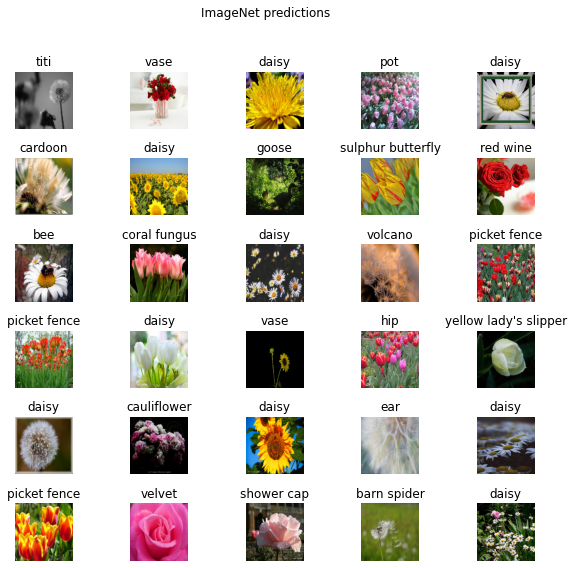

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
_________________________________________________________________
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 5])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
115/115 [==============================] - 97s 818ms/step - loss: 0.4508 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 93s 805ms/step - loss: 0.2698 - acc: 0.9062


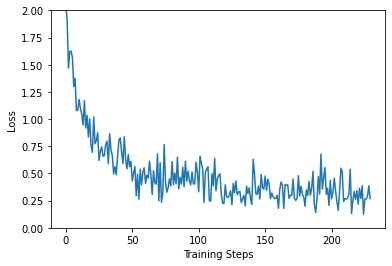

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

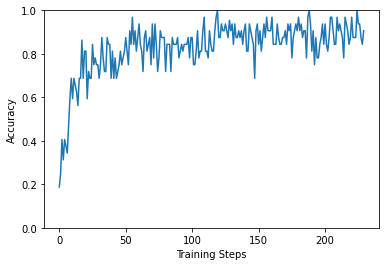

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

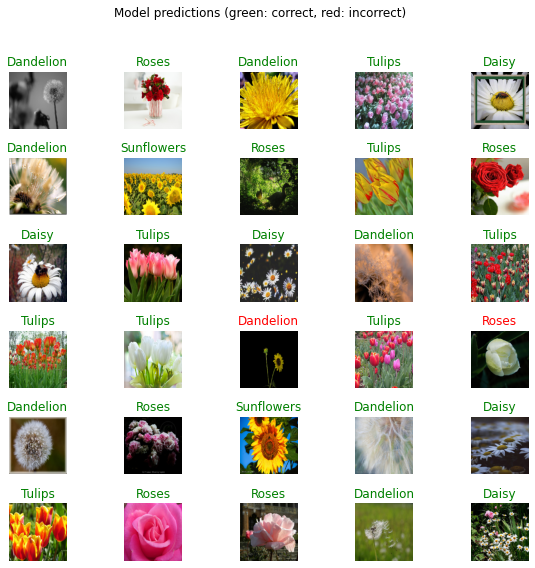

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1631412616/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1631412616/assets


'/tmp/saved_models/1631412616'

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0